In [1]:
import sys
import re
import pickle
from pathlib import Path
from functools import partial
from collections import Counter
from itertools import combinations
from multiprocessing.sharedctypes import RawArray

import torch
import json
import yaml
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pqdm.processes import pqdm
from IPython.core.display import HTML
from scipy.special import softmax, log_softmax
from scipy.spatial.distance import jensenshannon, cdist
from kneed import KneeLocator

import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors

sys.path.append("../soup_nuts/models/dvae/")

from dvae import data_iterator, CollapsedMultinomial, DVAE
from utils import load_sparse, compute_to

In [2]:
def load_json(path):
    with open(path) as infile:
        return json.load(infile)

def load_yaml(path):
    with open(path) as infile:
        return yaml.load(infile, Loader=yaml.FullLoader)

def load_text(path):
    with open(path) as infile:
        return [text.strip().split(" ") for text in infile]

def save_json(obj, path):
    with open(path, 'w') as outfile:
        return json.dump(obj, outfile, indent=2)

In [3]:
def topic_est_to_words(topic_words, inv_vocab, n=10):
    return [inv_vocab[idx] for idx in (-topic_words).argsort()[:n]]

In [4]:
_CUDA_AVAILABLE = torch.cuda.is_available()
_data_cache = {}

def load_mallet_estimates(fpath):
    """
    Load the doc-topic and topic-word estimates from our mallet output folder
    """
    topic_word = np.load(fpath / "beta.npy")
    # Load the standard mallet document-topic estimate as a numpy matrix
    with open(fpath / "doctopics.txt") as infile:
        doc_topic = np.array([
            [float(x) for x in line.strip().split("\t")[2:]]
            for line in infile
        ])
    return topic_word, doc_topic, None # TODO: is loss available in mallet?

def load_dvae_estimates_old(fpath): 
    """
    Loads the dvae model and gets the topic word distribution, then instantiates
    the encoder portion and does a forward pass to get the 
    """
    # get the topic word
    device = torch.device("cuda") if _CUDA_AVAILABLE else torch.device("cpu")

    state_dict = torch.load(fpath / "model.pt", map_location=device)
    beta = state_dict["params"]["decoder$$$eta_layer.weight"]
    topic_word = torch.transpose(beta, 0, 1).detach().numpy()

    # do a forward pass to get the document topics
    # first instantiate the model and load in the params
    config = load_yaml(fpath / "config.yml")
    encoder = Encoder(
        vocab_size=topic_word.shape[1],
        num_topics=config["num_topics"],
        embeddings_dim=config["encoder_embeddings_dim"],
        hidden_dim=config["encoder_hidden_dim"],
        dropout=config["dropout"],
    )
    encoder_dict = {
        k.replace("encoder$$$", ""): v
        for k, v in state_dict['params'].items() if k.startswith("encoder$$$")
    }
    encoder.load_state_dict(encoder_dict, strict=False)
    encoder.eval()

    # then load the data for the forward pass
    data_fpath = Path(config["input_dir"], config["train_path"])
    if data_fpath not in _data_cache:
        data = load_sparse(data_fpath).astype(np.float32)
        _data_cache[data_fpath] = data
    else:
        data = _data_cache[data_fpath]
    
    batch_size = config["batch_size"]
    epochs = config["num_epochs"]
    n = data.shape[0]
    train_batches = n // batch_size + 1

    # do the forward pass and collect outputs in an array
    doc_topic = np.zeros((n, config["num_topics"]), dtype=np.float32)
    for i, x_batch in enumerate(data_iterator(data, batch_size, train_batches)):
        x_batch = x_batch.to(device)
        doc_topic_batch = encoder(x_batch)

        doc_topic[i * batch_size:(i + 1) * batch_size] = doc_topic_batch.detach().cpu().numpy().astype(np.float32)

    # these are dirichlet parameters; take expectation
    doc_topic = doc_topic / doc_topic.sum(1, keepdims=True) # TODO: get log probs?

    return topic_word, doc_topic


def load_dvae_estimates(fpath): 
    """
    Loads the dvae model and gets the topic word distribution, then instantiates
    the encoder portion and does a forward pass to get the 
    """
    # get the topic word
    device = torch.device("cuda") if _CUDA_AVAILABLE else torch.device("cpu")

    state_dict = torch.load(fpath / "model.pt", map_location=device)
    beta = state_dict["params"]["decoder$$$eta_layer.weight"]
    topic_word = torch.transpose(beta, 0, 1).detach().numpy()

    # do a forward pass to get the document topics
    # first instantiate the model and load in the params
    config = load_yaml(fpath / "config.yml")
    
    dvae = DVAE(
        vocab_size=topic_word.shape[1],
        num_topics=config["num_topics"],
        alpha_prior=config["alpha_prior"],
        embeddings_dim=config["encoder_embeddings_dim"],
        hidden_dim=config["encoder_hidden_dim"],
        dropout=config["dropout"],
        cuda=_CUDA_AVAILABLE,
    )
    dvae_dict = {
        k.replace("$$$", "."): v
        for k, v in state_dict['params'].items()
    }
    dvae.load_state_dict(dvae_dict, strict=False)
    dvae.eval()
    turn_off_bn = 1 * (config["epochs_to_anneal_bn"] > 0) # 0 means use BN, > 0 means no BN

    # then load the data for the forward pass
    data_fpath = Path(config["input_dir"], config["train_path"])
    if data_fpath not in _data_cache:
        data = load_sparse(data_fpath).astype(np.float32)
        _data_cache[data_fpath] = data
    else:
        data = _data_cache[data_fpath]
    
    batch_size = config["batch_size"]
    epochs = config["num_epochs"]
    n = data.shape[0]
    train_batches = n // batch_size + 1

    # do the forward pass and collect outputs in an array
    doc_topic = np.zeros((n, config["num_topics"]), dtype=np.float32)
    losses = np.zeros(n, dtype=np.float32)
    for i, x_batch in enumerate(data_iterator(data, batch_size, train_batches)):
        x_batch = x_batch.to(device)
        doc_topic_batch = dvae.encoder(x_batch)
        doc_topic_batch = doc_topic_batch / doc_topic_batch.sum(1, keepdims=True)
        x_recon = dvae.decoder(doc_topic_batch, bn_annealing_factor=turn_off_bn)
        loss_batch = -CollapsedMultinomial(1, probs=x_recon).log_prob(x_batch)

        doc_topic[i * batch_size:(i + 1) * batch_size] = doc_topic_batch.detach().cpu().numpy().astype(np.float32)
        losses[i * batch_size:(i + 1) * batch_size] = loss_batch.detach().cpu().numpy().astype(np.float32)
    return topic_word, doc_topic, losses


def load_estimates(fpath, model_type):
    if model_type == "dvae":
        return load_dvae_estimates(fpath)
    if model_type == "mallet":
        return load_mallet_estimates(fpath)

In [5]:
def detect_topic_knees(doc_topic, knee_sensitivity=1.0):
    """
    For each topic in a document-topic matrix of probability estimates,
    sort the document probabilities for that topic and determine the "knee" in the
    curve after which documents are likely not to be related to that topic
    """
    n, k = doc_topic.shape
    topic_knees = np.zeros(k)

    for k_idx in range(k):
        kneedle = KneeLocator(
            x=np.arange(n),
            y=-np.sort(-doc_topic[:, k_idx]),
            S=knee_sensitivity,
            curve="convex",
            direction="decreasing",
            online=True,
        )
        topic_knees[k_idx] = kneedle.knee_y

    return topic_knees

In [6]:
def calculate_recon_loss(doc_topic, topic_word, data, batchsize=10_000, pbar=None):
    """
    Given estimates from the model, calculate the cross-entropy between the 
    estimated document word distribution and the true one
    TODO: ~just use model class directly?~ -> done
    TODO: figure out why the below was wrong? was it just the normalization?
    """
    raise ValueError("deprecated")
    n = doc_topic.shape[0]
    x_ent = np.zeros(n)
    for i in range(n // batchsize + 1):
        bs = np.s_[i*batchsize:(i+1)*batchsize]
        p_hat = softmax(doc_topic[bs] @ topic_word, axis=1)
        x_ent[bs] = np.sum(data[bs].toarray() * np.log(p_hat), axis=1) / np.sum(data[bs].toarray() == 0, axis=1)
        if pbar is not None:
            pbar.update()
    return x_ent


def estimate_document_loss_stability(run_estimates, data, argmax_topic=False, batchsize=10_000):
    """
    Given a collection of estimates of document-topic distributions, determine 
    how stable their topic assignments are by comparing the perplexity changes
    """
    raise ValueError("deprecated")
    runs = len(run_estimates)
    n = run_estimates[0][1].shape[0]
    losses = np.zeros((n, runs))
    
    for i, (topic_word, doc_topic) in enumerate(tqdm(run_estimates)):
        if argmax_topic:
            doc_topic = doc_topic == doc_topic.max(1)
        losses[:, i] = calculate_recon_loss(doc_topic, topic_word, data, batchsize)
    return losses


def estimate_document_word_stability(doc_topics, topic_words, top_n=15):
    """
    Given a collection of estimates of document-topic distributions, determine
    how stable the topic assignments are by comparing the set of top words

    TODO: just uses top topic for now
    """
    runs = len(doc_topics)
    n = doc_topics[0].shape[0]
    top_words_over_runs = np.zeros((n, runs * top_n))
    probs = np.zeros((n, runs))
    
    for i, (doc_topic, topic_word) in enumerate(tqdm(zip(doc_topics, topic_words), total=runs)):
        top_words = (-topic_word).argsort()[:, :top_n]
        top_words_over_runs[:, i*top_n:(i+1)*top_n] = top_words[doc_topic.argmax(1)]
             #* (doc_topic.max(1, keepdims=True) >= min_prob)
        #)
        probs[:, i] = doc_topic.max(1)

    # https://stackoverflow.com/questions/48473056/number-of-unique-elements-per-row-in-a-numpy-array
    nunique = np.count_nonzero(np.diff(np.sort(top_words_over_runs)), axis=1) + 1
    punique = (nunique - n_topic_words) / (n_topic_words * (runs - 1))
    return nunique, punique, probs


def calc_dists(batch_idx, batchsize, run_estimates):
    bs = np.s_[batch_idx*batchsize:(batch_idx+1)*batchsize]
    # create a set of batch x vocab document-word estimates per run
    p_hat_batch = (softmax(d[bs] @ t, axis=1) for t, d in run_estimates)
    # calculate pairwise distances between doc-word estimates for all runs
    dists = np.array([
        jensenshannon(p_a, p_b, axis=1) for p_a, p_b in combinations(p_hat_batch, 2)
    ])
    return dists.mean(0), dists.std(0)


def estimate_document_stability(run_estimates, argmax_topic=False, batchsize=1_000, n_jobs=1):
    """
    Given a collection of estimates of document-topic distributions, determine 
    how stable their topic assignments are
    """
    if argmax_topic:
        for i in len(run_estimates):
            d = run_estimates[i][1]
            run_estimates[i][1] = d == d.max(1)

    runs = len(run_estimates)
    k, v = run_estimates[0][0].shape
    n, k = run_estimates[0][1].shape

    topic_words_arr = RawArray(np.ctypeslib.as_ctypes_type(run_estimates[0][0].dtype), runs * k * v)
    doc_topics_arr = RawArray(np.ctypeslib.as_ctypes_type(run_estimates[0][0].dtype), runs * n * k)
    
    batch_idxs = list(range(n // batchsize + 1))
    calc_dists_wrapped = partial(calc_dists, batchsize=batchsize, run_estimates=run_estimates)
    result = pqdm(batch_idxs, calc_dists_wrapped, n_jobs=n_jobs)
    return result
    dists_means = np.concatenate([m for m, s in result])
    dist_stds = np.concatenate([s for m, s in result])
    return dists_means, dist_stds


In [109]:
def estimate_topic_stability(topic_words, iters=1, sample_n=1, softmax_ests=False, seed=None):
    """
    Estimate the stability of topics by running pairwise comparisons
    of all runs: take the js-divergence of the topic pairs, then match each topic
    with its closest pair, per run. Repeat `iters` times to get a "pseudo-best" matching

    To speed up computation, can set `sample_pct` to use only a subset of possible combinations
    """
    np.random.seed(seed)
    num_topics = topic_words[0].shape[0]
    runs = len(topic_words)
    combins = (runs * (runs - 1)) // 2
    sample_pct = sample_n if sample_n <= 1 else sample_n / combins
    to_keep = [np.random.rand() <= sample_pct for _ in range(combins)]
    kept = sum(to_keep)
    min_dists = np.zeros((kept, num_topics))
    c = 0
    if softmax_ests:
        topic_words = [softmax(t, axis=1) for t in topic_words]
    pbar = tqdm(range(kept))
    for keep, (t_a, t_b) in zip(to_keep, (combinations(topic_words, 2))):
        if not keep:
            continue
        dists = cdist(t_a, t_b, metric='jensenshannon')

        # algorithm is greedy: we randomize every iteration to get a pseudo-best estimate
        # of the distances
        for i in range(iters):
            dists_ = dists[np.random.permutation(num_topics), :].copy()

            min_dists_i = np.zeros(num_topics)
            for k in range(num_topics):
                min_idx = dists_[k].argmin() # match this topic to its lowest pair
                min_dists_i[k] = dists_[k, min_idx] # record this minimum distance
                dists_[k+1:, min_idx] = 1. # remove this index from consideration for later topics
            if i == 0 or min_dists_i.mean() < min_dists[c].mean():
                min_dists[c] = np.sort(min_dists_i)
        c += 1
        pbar.update()
    pbar.close()
    return min_dists

def estimate_effective_topics(topic_words, iters):
    pass

In [8]:

def highlight_doc(doc, prob, vocab, global_scaling=True):
    """
    Highlight a document based on the word-to-probability map `prob`
    """
    doc_toks = doc.split()
    min_idx = prob.argmin()
    doc_probs = [prob[vocab.get(tok.lower(), min_idx)] for tok in doc_toks]
    if global_scaling:
        min_prob, max_prob = np.min(prob), np.max(prob)
    else:
        min_prob, max_prob = np.min(doc_probs), np.max(doc_probs)

    norm = matplotlib.colors.Normalize(vmin=min_prob, vmax=max_prob, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)

    tag = "<span style='background-color: {color}'><b>{token}</b></span>"
    tagged_tokens = [
        tag.format(
            color=mcolors.to_hex(mapper.to_rgba(prob)).upper(),
            token=token,
        )
        for token, prob in zip(doc_toks, doc_probs)
    ]
    sent = ' '.join(tagged_tokens)
    return HTML(sent)

collect the runs

In [9]:
# roughly 7 GB RAM for k=100
def get_estimates_over_runs(run_paths, overlap_words, exclude_dups=False):
    doc_topics, topic_words, duplicates, losses = [], [], [], [] # TODO: change to 3d tensors
    for i, (p, model_type) in enumerate(tqdm(run_paths)):
        t, d, l = load_estimates(p, model_type=model_type)
        
        # located duplicated topics
        sorted_t = np.sort((-t).argsort(axis=1)[:, :overlap_words], axis=1)
        counted_topics = Counter([tuple(t_) for t_ in sorted_t])
        if exclude_dups and max(counted_topics.values()) > 1:
            continue
        doc_topics.append(d)
        topic_words.append(t)
        duplicates.append(sum(c > 1 for c in counted_topics.values()))
        losses.append(l) # TODO fix for mallet

    if losses[0] is not None:
        losses = np.array(losses).T
    return doc_topics, topic_words, duplicates, losses

In [77]:
#run_dir = "../runs/outputs/url_partisanship_data"
run_dir = "../runs/outputs/full-mindf_power_law-maxdf_0.9"
dataset = 'wikitext' #'url_partisan'

mallet_paths = [
    (p.parent, "mallet")
    for p in Path(run_dir).glob("**/mallet-with-beta/**/doctopics.txt")
    if dataset in str(p)
]
dvae_paths = [
    (p.parent, "dvae") for p in Path(run_dir).glob("**/dvae/**/model.pt")
    if dataset in str(p)
]

config = load_yaml(dvae_paths[0][0] / "config.yml")
data = load_sparse(Path(config["input_dir"], "train.dtm.npz"))
vocab = load_json(Path(config["input_dir"], "vocab.json"))
inv_vocab = {v: k for k, v in vocab.items()}

In [78]:
num_topics = sorted(set(int(re.search("k-([0-9]+)", str(p)).group(1)) for p in dvae_paths))
num_topics

[50]

In [80]:
n_topic_words = 15
overlap_words = 5

In [82]:
estimates_dvae, estimates_mallet = {}, {}
for k in num_topics:
    print(f"On k={k}")

    dvae_paths_k = [p for p in dvae_paths if f'k-{k}/' in str(p[0])]
    runs = len(dvae_paths_k)
    doc_topics, topic_words, duplicates, losses = get_estimates_over_runs(dvae_paths_k, overlap_words, exclude_dups=False)
    estimates_dvae[k] = {"doc_topics": doc_topics, "topic_words": topic_words, "duplicates": duplicates, "losses": losses}
    
    mallet_paths_k = [p for p in mallet_paths if f'k-{k}/' in str(p[0])]
    if mallet_paths_k:
        doc_topics, topic_words, duplicates, losses = get_estimates_over_runs(mallet_paths_k, overlap_words, exclude_dups=False)
        estimates_mallet[k] = {"doc_topics": doc_topics, "topic_words": topic_words, "duplicates": duplicates, "losses": losses}
with open(f"dvae-{dataset}-estimates.pkl", "wb") as outfile:
    pickle.dump(estimates_dvae, outfile)

On k=50


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [83]:
exclude_dupes = lambda data, dupe: [x for x, d in zip(data, dupe) if d == 0]

In [ ]:
# TODO: run over mallet as well
data = {}
data_without_dupes = {}

for k, est in estimates_dvae.items():
    doc_topics, topic_words, duplicates, losses = (
        est["doc_topics"], est["topic_words"], est["duplicates"], est["losses"]
    )
    for exclude in [False, True]:
        dt, tw = doc_topics, topic_words
        if exclude:
            dt, tw = exclude_dupes(dt, duplicates), exclude_dupes(tw, duplicates)
        nunique, punique, probs = estimate_document_word_stability(dt, tw, top_n=n_topic_words)
        pct_assigned = (probs < 0.5).mean(1)
        nsummary = pd.Series(nunique).describe()
        psummary = pd.Series(punique).describe()
        asummary = pd.Series(pct_assigned).describe()
        if not exclude:
            data.update({f"pct_unique_{k}": psummary, f"nuniuqe_{k}": nsummary, f"assigned_{k}": asummary})
        else:
            data_without_dupes.update({f"pct_unique_{k}": psummary, f"nuniuqe_{k}": nsummary, f"assigned_{k}": asummary})

data = pd.DataFrame(data)
data_without_dupes = pd.DataFrame(data_without_dupes)

In [ ]:
data.to_csv("stability_summary-dvae-url_partisan-20220305.csv")
data_without_dupes.to_csv("stability_summary_dedup-dvae-url_partisan-20220305.csv")

,a,b
count,176377.000000,176377.000000
mean,0.749403,0.438181
std,0.175117,0.137653
min,0.142857,0.150000
25%,0.619048,0.326667
50%,0.761905,0.436667
75%,0.904762,0.540000
max,1.000000,0.886667


In [ ]:
data

In [ ]:
data_without_dupes

In [110]:
data, data_without_dupes = {"mallet": {}, "dvae": {}},  {"mallet": {}, "dvae": {}}
for model, estimates in [("mallet", estimates_mallet), ("dvae", estimates_dvae)]:
    for k, est in estimates.items():
        _, topic_words, duplicates, _ = (
            est["doc_topics"], est["topic_words"], est["duplicates"], est["losses"]
        )
        for exclude in [False,  True]:
            tw = topic_words
            if exclude:
                tw = exclude_dupes(tw, duplicates)
            dists = estimate_topic_stability(tw, softmax_ests=model=='dvae', sample_n=20, seed=42)
            summary = pd.Series(dists.flatten()).describe()
            if not exclude:
                data[model][f"min_dists_{k}"] = summary
            else:
                data_without_dupes[model][f"min_dists_{k}"] = summary

data = pd.concat({k: pd.DataFrame(v) for k, v in data.items()})
data_without_dupes = pd.concat({k: pd.DataFrame(v) for k, v in data_without_dupes.items()})

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [111]:
data

min_dists_50
mallet count    750.000000
       mean       0.307692
       std        0.178525
       min        0.038807
       25%        0.162107
       50%        0.266771
       75%        0.424182
       max        0.739950
dvae   count    850.000000
       mean       0.346190
       std        0.168464
       min        0.010362
       25%        0.217179
       50%        0.341245
       75%        0.466584
       max        0.785016

In [112]:
data_without_dupes

min_dists_50
mallet count    800.000000
       mean       0.309814
       std        0.188465
       min        0.038910
       25%        0.149584
       50%        0.265610
       75%        0.449991
       max        0.741086
dvae   count   1100.000000
       mean       0.324987
       std        0.158932
       min        0.003325
       25%        0.205337
       50%        0.319458
       75%        0.447440
       max        0.716815

In [71]:
try:
    doc_ids = load_json(Path(config["input_dir"], "train.ids.json"))
    doc_ids = [int(i.split(":")[1]) for i in doc_ids]
except FileNotFoundError:
    with open(Path(config["input_dir"], "train.metadata.jsonl")) as infile:
        doc_ids = [json.loads(line)['id'] for line in infile]
    
assert(len(doc_ids) == doc_topics[0].shape[0])

In [76]:
#loss_stds = losses.std(1)
selected_idxs = (-nunique).argsort()[:10]
selected_doc_ids = [doc_ids[i] for i in selected_idxs] # get the associated ids, to map back to raw text

# get raw text info
preproc_params = load_json(Path(config["input_dir"], "params.json"))
raw_file = Path("../", preproc_params["input_path"])
is_jsonl = preproc_params["input_format"] == "jsonl"
if is_jsonl:
    id_key, text_key = preproc_params["jsonl_id_key"], preproc_params["jsonl_text_key"]
selected_docs = []

with open(raw_file) as infile:
    for i, line in enumerate(infile):
        if is_jsonl:
            data = json.loads(line)
            id = data[id_key]
            text = data[text_key]
        else:
            id = i
            text = line

        if id in selected_doc_ids:
            idx = doc_ids.index(id)
            assigned_topics = [
                topic_est_to_words(t[d[idx].argmax()], inv_vocab, n=n_topic_words)
                for t, d in zip(topic_words, doc_topics)
            ]
            assigned_words = Counter([w for topic in assigned_topics for w in topic])
            assigned_topics = sorted(assigned_topics, key=lambda t: -sum(assigned_words[w] for w in t))
            selected_docs.append((nunique[idx], id, text, assigned_topics, assigned_words))

In [77]:
for score, id, doc, topics, words in sorted(selected_docs, key=lambda k: -k[0]):
    print(f"doc id: {id}")
    print(f"score: {score:0.3f}")
    print("== document sample ==")
    print(doc[:200])
    print("\n========topics=======")
    uniq_words = len(words) / (n_topic_words * len(topic_words))
    print(f"unique words: {len(words)}")
    print(f"percentage of unique words {uniq_words:0.1%}\n")
    print("\n".join(" ".join(t) for t in topics))
    print("\n############################\n")

doc id: 15430
score: 688.000
== document sample ==
 Henri L 'Estrange = Henri L 'Estrange , known as the Australian Blondin , was an Australian successful funambulist and accident prone aeronautical balloonist . Modelling himself on the famous French 

========topics=======
unique words: 688
percentage of unique words 55.9%

ernest_shackleton shackleton sledging royal_geographical_society duchess governess sledges south_georgia highness south_pole boatswain saxe antarctic expedition godparents
rower rowed rowing cambridge oxford umpired university_of_cambridge university_of_oxford lengths mile_post race hammersmith_bridge boat_race rowers goldie
rower rowed rowing cambridge oxford umpired university_of_cambridge university_of_oxford lengths mile_post race hammersmith_bridge boat_race rowers goldie
cambridge oxford rowed rowing coaster rower race lengths roller ride blues boat flag crews flags
locomotives trains locomotive electrification railways freight electrified coaster nsb ridersh

In [51]:
estimates_sample = [(t, d[:100]) for t, d in estimates_k]
result = estimate_document_stability(estimates_sample, argmax_topic=False, batchsize=10, n_jobs=30)

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

Process ForkProcess-164:
Traceback (most recent call last):
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/workspace/.conda/envs/pyro-1.6/lib/python3.9/multiprocessing/connection.py", line 384, in _rec

KeyboardInterrupt: 

In [ ]:
result[-1]

In [30]:
dists_mean, dists_std = estimate_document_stability(estimates_k, argmax_topic=False, batchsize=100, n_jobs=30)

QUEUEING TASKS | :   0%|          | 0/1764 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1764 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1764 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable AttributeError object

investigate particular runs

In [7]:
path = Path("../runs/outputs/full-mindf_power_law-maxdf_0.9/wikitext/k-50/dvae/alpha_0.01-lr_0.01-h2dim_0-reg_0.0-epochs_500-anneal_bn_1-anneal_kl_100/42")
topic_word, doc_topic = load_estimates(path, "dvae")
config = load_yaml(path / "config.yml")
data = load_sparse(Path(config["input_dir"], "train.dtm.npz"))
vocab = load_json(Path(config["input_dir"], "vocab.json"))

In [8]:
last_epoch = config["num_epochs"] - 2
topics = (path / "topics" / f"{last_epoch}.txt").read_text().split("\n")

In [11]:
knees = detect_topic_knees(doc_topic)
knees

array([1.27908628e-04, 5.67574345e-04, 4.70940613e-05, 9.96566359e-06,
       3.64140178e-05, 6.05246925e-04, 1.40915217e-05, 6.02179462e-05,
       6.35557371e-05, 1.35947150e-04, 7.50828549e-05, 6.71530259e-04,
       1.59733754e-04, 7.03677870e-05, 7.29089443e-05, 7.67615216e-04,
       2.00844894e-04, 7.98513429e-05, 9.03163382e-05, 1.75799520e-04,
       1.21973490e-03, 2.34646177e-05, 6.65480256e-05, 8.85034478e-06,
       1.46946695e-04, 3.24910252e-05, 5.50855875e-05, 1.14984061e-04,
       4.97004343e-03, 2.00305789e-04, 1.55346032e-04, 4.82494070e-05,
       7.00944802e-05, 1.24289596e-03, 2.27889439e-04, 9.50739812e-03,
       3.05540918e-04, 1.06113439e-05, 2.85003389e-05, 3.86550528e-05,
       8.94571072e-04, 1.45636368e-04, 6.96296320e-06, 2.85115006e-04,
       2.41323105e-05, 1.89575498e-04, 1.90472929e-05, 1.27517473e-04,
       1.99067454e-05, 4.82360738e-05])

In [12]:
docs_above_threshold = np.where(doc_topic > knees)[0]
len(np.unique(docs_above_threshold))

28472

In [55]:
recon_loss = calculate_recon_loss(doc_topic, topic_word, data)

In [56]:
recon_loss

array([-0.34736099, -0.32949728, -0.25358216, ..., -0.11415611,
       -0.06411184, -0.1300174 ])

In [58]:
import pandas as pd
topics_by_mean_loss = (
    pd.DataFrame({"recon_loss": recon_loss, "top_topic": doc_topic.argmax(1)})
      .groupby("top_topic", as_index=False)
      .median()
      .sort_values("recon_loss")
      .merge(pd.DataFrame({"top_topic": range(len(topics)), "topic_words": topics}))
)
topics_by_mean_loss

,top_topic,recon_loss,topic_words
0,19,-0.503722,rotten_tomatoes roger_ebert film screenplay gr...
1,5,-0.456385,epidemiology symptoms clinical diagnosis thera...
2,16,-0.432930,infantry flank casualties battalion battalions...
3,12,-0.409609,theory philosopher empirical philosophers thin...
4,7,-0.406828,supreme_court constitutional courts statutory ...
5,38,-0.386513,demographics census capita united_states_censu...
6,11,-0.360966,composer composers orchestral opera soloists c...
7,44,-0.354983,aircraft bombers bomber pilots destroyers sort...
8,2,-0.353751,house_of_commons church_of_england protestant ...
9,13,-0.348195,demography parish constituency councillors dom...


Investigate particular topics

In [9]:
idx = 33 # below is DVAE-logic
topics[idx]

'tropical landfall cyclone utc weakening intensify dissipated storm weakened hurricane saffir intensification intensified joint_typhoon_warning_center intensity mbar convection dissipating winds trough inhg barometric shear northwestward circulation caribbean_sea extratropical meteorological jtwc national_hurricane_center weaken westward northeastward downgraded strengthened mph degenerated attained intensifying operationally gusts disturbance storms southwestward gulf_of_mexico rainfall strengthening gusty tracked advisories'

In [10]:
kn = KneeLocator(
    x=np.arange(doc_topic.shape[0]),
    y=-np.sort(-doc_topic[:, idx]),
    S=1, curve="convex",
    direction="decreasing",
    online=True,
)

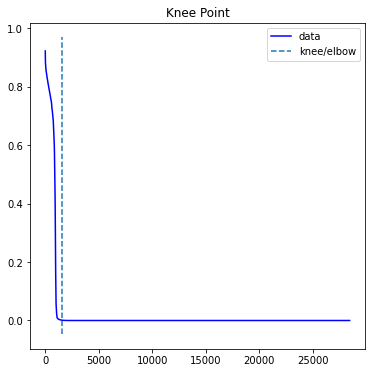

In [12]:
kn.plot_knee()

In [11]:
kn.knee, kn.knee_y

(1533, 0.001242896)

In [13]:
d = doc_topic[:, idx] - kn.knee_y
selected_idxs = np.where((doc_topic[:, idx] >= kn.knee_y) & (idx == doc_topic.argmax(1)))[0]
len(selected_idxs)

904

In [15]:
config = load_yaml(path / "config.yml")
doc_ids = load_json(Path(config["input_dir"], "train.ids.json"))
selected_doc_ids = [doc_ids[i] for i in selected_idxs]
raw_file = Path("../", selected_doc_ids[0].split(":")[0])
selected_doc_ids = [int(i.split(":")[1]) for i in selected_doc_ids]

In [16]:
selected_docs = []
with open(raw_file) as infile:
    for i, line in enumerate(infile):
        if i in selected_doc_ids:
            selected_docs.append((doc_topic[i, idx], i, line))

for score, i, line in sorted(selected_docs, key=lambda k: -k[0]):
    print(f"{score:0.2f}", i, line[:100])

0.92 17499  1907 Atlantic hurricane season = The 1907 Atlantic hurricane season was at one point the only Atlan
0.92 18533  Hurricane Octave ( 1989 ) = Hurricane Octave was a Category 4 hurricane which existed during the ab
0.92 21710  Hurricane Fran ( 1973 ) = Hurricane Fran , also referred initially as Subtropical storm Bravo , was
0.91 4144  Tropical Storm Nicholas ( 2003 ) = Tropical Storm Nicholas was a long-lived tropical storm in Octob
0.90 7994  Hurricane Irene ( 2005 ) = Hurricane Irene was a long-lived Cape Verde-type Atlantic hurricane duri
0.90 11335  2002 – 03 Australian region cyclone season = The 2002 – 03 Australian region cyclone season include
0.90 17411  2006 Pacific hurricane season = The 2006 Pacific hurricane season was the most active since 2000 , 
0.89 16317  Cyclone Urmil ( 2006 ) = Tropical Cyclone Urmil ( RSMC Nadi designation : 06F , JTWC designation : 
0.89 25664  1949 Pacific hurricane season = The 1949 Pacific hurricane season was the first hurricane seas

document highlighting

In [19]:
highlight_doc(selected_docs[0][-1], topic_word[idx])

AttributeError: 'numpy.ndarray' object has no attribute 'get'